# Assignment 1 by Qingxin Meng

The best way to test this code is to run the blocks sequentially, since there are functions and variables being modified multiple times.

This ipynb is tested in Google colab by executing `Run all`.

# Absolute camera orientation given set of relative camera pairs

The problem we deal with is defined as follows:

Given an optical system of $N$ cameras with extrinsics $\{g_1, ..., g_N | g_i \in SE(3)\}$, and a set of relative camera positions $\{g_{ij} | g_{ij}\in SE(3)\}$ that map between coordinate frames of randomly selected pairs of cameras $(i, j)$, we search for the absolute extrinsic parameters $\{g_1, ..., g_N\}$ that are consistent with the relative camera motions.

More formally:
$$
g_1, ..., g_N =
{\arg \min}_{g_1, ..., g_N} \sum_{g_{ij}} d(g_{ij}, g_i^{-1} g_j),
$$,
where $d(g_i, g_j)$ is a suitable metric that compares the extrinsics of cameras $g_i$ and $g_j$.

Visually, the problem can be described as follows. The picture below depicts the situation at the beginning of our optimization. The ground truth cameras are plotted in purple while the randomly initialized estimated cameras are plotted in orange:


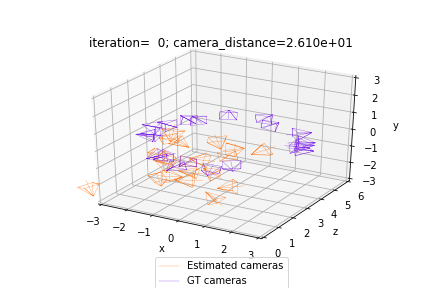

Our optimization seeks to align the estimated (orange) cameras with the ground truth (purple) cameras, by minimizing the discrepancies between pairs of relative cameras. Thus, the solution to the problem should look as follows:

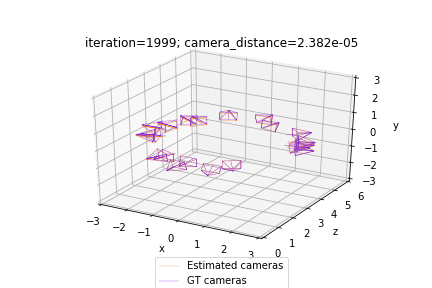

In practice, the camera extrinsics $g_{ij}$ and $g_i$ are represented using objects from the `PerspectiveCameras` class initialized with the corresponding rotation and translation matrices `R_absolute` and `T_absolute` that define the extrinsic parameters $g = (R, T); R \in SO(3); T \in \mathbb{R}^3$. In order to ensure that `R_absolute` is a valid rotation matrix, we represent it using an exponential map (implemented with `so3_exponential_map`) of the axis-angle representation of the rotation `log_R_absolute`.

## 0. Install and Import Modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("2.2.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [2]:
# imports
import matplotlib.pyplot as plt
import torch
from pytorch3d.transforms.so3 import (
    so3_exponential_map,
    so3_relative_angle,
)
from pytorch3d.renderer.cameras import (
    PerspectiveCameras,
)

from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    RasterizationSettings, PointLights, MeshRenderer,
    MeshRasterizer, SoftPhongShader
)

# add path for demo utils
import sys
import os
sys.path.append(os.path.abspath(''))

# set for reproducibility
torch.manual_seed(777)
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("WARNING: CPU only, this will be slow!")

If using **Google Colab**, fetch the utils file for plotting the camera scene, and the ground truth camera positions:

In [3]:
!wget https://raw.githubusercontent.com/hallpaz/3dsystems23/master/scripts/camera_visualization.py
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
from camera_visualization import plot_camera_scene
from plot_image_grid import image_grid

!mkdir data
!wget -P data https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/data/camera_graph.pth

--2024-03-30 22:25:36--  https://raw.githubusercontent.com/hallpaz/3dsystems23/master/scripts/camera_visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2178 (2.1K) [text/plain]
Saving to: ‘camera_visualization.py.3’

camera_visualizatio 100%[===================>]   2.13K  --.-KB/s    in 0s      

2024-03-30 22:25:36 (39.1 MB/s) - ‘camera_visualization.py.3’ saved [2178/2178]

--2024-03-30 22:25:36--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent

OR if running **locally** uncomment and run the following cell:

In [4]:
# from utils import plot_camera_scene
# from utils import image_grid

## 1. Set up Cameras and load ground truth positions

In [5]:
# load the SE3 graph of relative/absolute camera positions
camera_graph_file = './data/camera_graph.pth'
(R_absolute_gt, T_absolute_gt), \
    (R_relative, T_relative), \
    relative_edges = \
        torch.load(camera_graph_file)

# create the relative cameras
cameras_relative = PerspectiveCameras(
    R = R_relative.to(device),
    T = T_relative.to(device),
    device = device,
)

# create the absolute ground truth cameras
cameras_absolute_gt = PerspectiveCameras(
    R = R_absolute_gt.to(device),
    T = T_absolute_gt.to(device),
    device = device,
)

# the number of absolute camera positions
N = R_absolute_gt.shape[0]


1.1 Check the ground truth values for rotation and translation of the first camera $g_0$. Do they look like measured values or arbitrary ones? Why do you think this decision was taken?

In [6]:
##############################################################################
# Code and explanation for 1.1
# Discussion is shown in below section.
##############################################################################
print(R_absolute_gt[0])
print(T_absolute_gt[0])

#random 2 cameras
print(R_absolute_gt[10:12])


tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
tensor([-0., -0., -0.])
tensor([[[ 8.6876e-01,  6.7044e-04,  4.9524e-01],
         [-3.7999e-02,  9.9714e-01,  6.5309e-02],
         [-4.9378e-01, -7.5556e-02,  8.6630e-01]],

        [[ 1.7377e-01,  1.4587e-01,  9.7392e-01],
         [-1.1740e-01,  9.8499e-01, -1.2658e-01],
         [-9.7776e-01, -9.2339e-02,  1.8828e-01]]])


## Discussion for 1.1

With comparison with the ground truth values for rotation and translation of other cameras, those of the first camera are intentionally set to be reference values, so they are arbitrary values instead of exact measured values. We can easily figure out that the rotation matrix is identity matrix and the translation vector is 3d zero vector. That means there is no rotation and translation for the first camera. Therefore, it suggests that the first camera is likely designated as the base camera at the origin of the coordinate system.

## 2. Define optimization functions

### Relative cameras and camera distance
We now define two functions crucial for the optimization.

**`calc_camera_distance`** compares a pair of cameras. This function is important as it defines the loss that we are minimizing. The method utilizes the `so3_relative_angle` function from the SO3 API.

**`get_relative_camera`** computes the parameters of a relative camera that maps between a pair of absolute cameras. Here we utilize the `compose` and `inverse` class methods from the PyTorch3D Transforms API.

In [7]:
def calc_camera_distance(cam_1, cam_2):
    """
    Calculates the divergence of a batch of pairs of cameras cam_1, cam_2.
    The distance is composed of the cosine of the relative angle between
    the rotation components of the camera extrinsics and the L2 distance
    between the translation vectors.
    """
    # rotation distance
    R_distance = (1.-so3_relative_angle(cam_1.R, cam_2.R, cos_angle=True)).mean()
    # translation distance
    T_distance = ((cam_1.T - cam_2.T)**2).sum(1).mean()
    # the final distance is the sum
    return R_distance + T_distance

def get_relative_camera(cams, edges):
    """
    For each pair of indices (i,j) in "edges" generate a camera
    that maps from the coordinates of the camera cams[i] to
    the coordinates of the camera cams[j]
    """

    # first generate the world-to-view Transform3d objects of each
    # camera pair (i, j) according to the edges argument
    trans_i, trans_j = [
        PerspectiveCameras(
            R = cams.R[edges[:, i]],
            T = cams.T[edges[:, i]],
            device = device,
        ).get_world_to_view_transform()
         for i in (0, 1)
    ]

    # compose the relative transformation as g_i^{-1} g_j
    trans_rel = trans_i.inverse().compose(trans_j)

    # generate a camera from the relative transform
    matrix_rel = trans_rel.get_matrix()
    cams_relative = PerspectiveCameras(
                        R = matrix_rel[:, :3, :3],
                        T = matrix_rel[:, 3, :3],
                        device = device,
                    )
    return cams_relative

2.1 In this task, we are parameterizing the 3D rotation group - $SO(3)$ - using rotation matrices. This choice has some drawbacks, as we need to ensure our matrices are valid rotation matrices. Which other choice(s) could we have used to parameterize rotations? Would it be a better choice?

In [8]:
##############################################################################
# Explanation for 2.1
# Explanation is in below text section.
##############################################################################

 ##  Explanation for 2.1
 There are several ways to parameterize rotation in SO(3).

 Axis and angle of rotation: This is to find a unit vector u in $S^2$ as the rotation axis, and a $\theta$ as the rotation angle. Although this method is intuitive and can avoid gimbal lock, the vector u is hard to be calculated. And this parameterization is singular when $\theta=0$.

 Euler angle: Apply 3 consecutive rotation about the coordinate z, x and z of canonical basis. And the angles $\phi, \psi, \theta$ is called Euler's angles. This parameterization is used in study of rigid body dynamics in $R^3$ . Using rotation matric to describe Euler's angles leads to gimbal lock.

 Quaternions: This defines rotation based on the "axis and angle of rotation" model by using complex numbers.

 ## The better choice

 Quaternions is a better choice compared to parameterize rotations, since quaternions has many advantages listed below.

 In practise, quaternions has only 4 components stored in float data in computer, occupying a relative small space.

 The parameterization is global, enabling interpolation of rotations.

 Based on "axix and angle", the parameterization is intrinsic.

 Quaterion product is easy to implement compared to matrix product.


## 3. Optimization
Finally, we start the optimization of the absolute cameras.

We use SGD with momentum and optimize over `log_R_absolute` and `T_absolute`.

As mentioned earlier, `log_R_absolute` is the axis angle representation of the rotation part of our absolute cameras. We can obtain the 3x3 rotation matrix `R_absolute` that corresponds to `log_R_absolute` with:

`R_absolute = so3_exponential_map(log_R_absolute)`


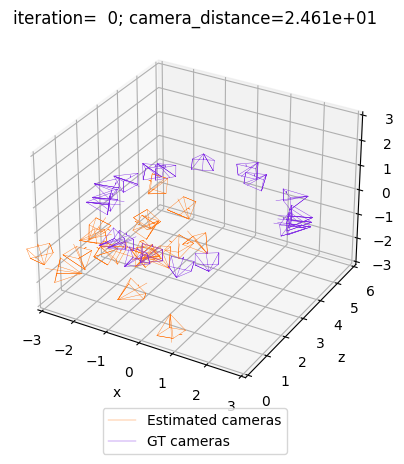

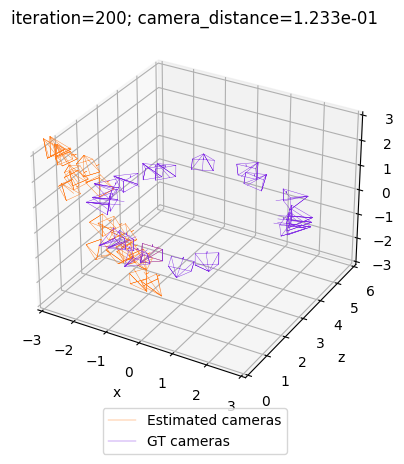

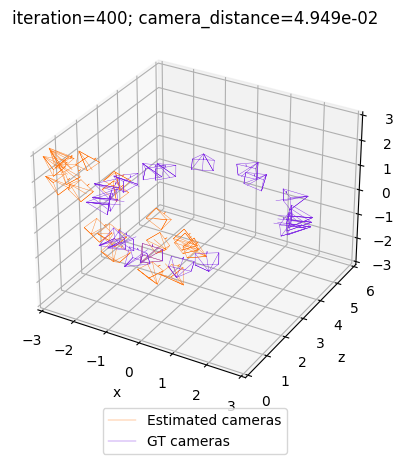

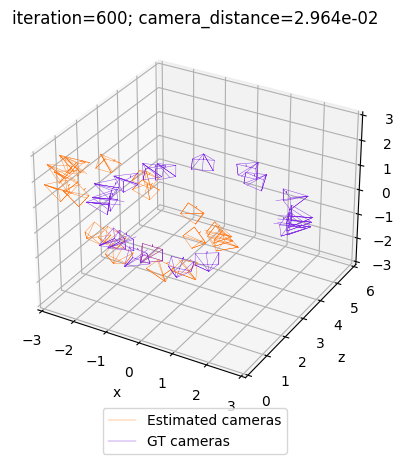

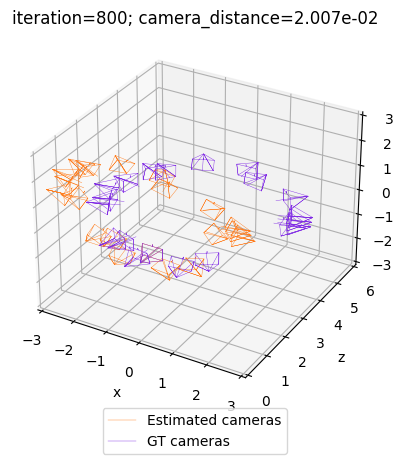

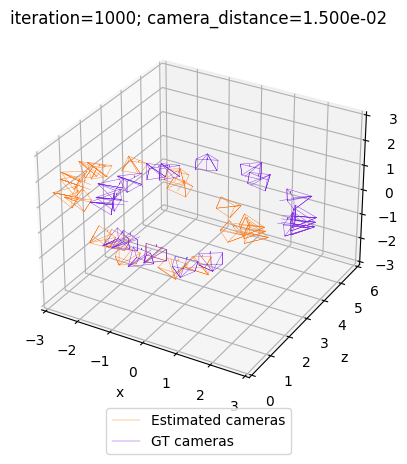

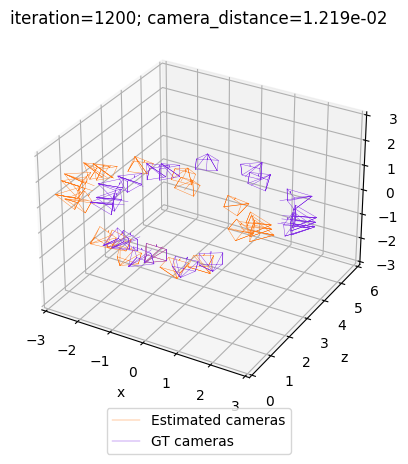

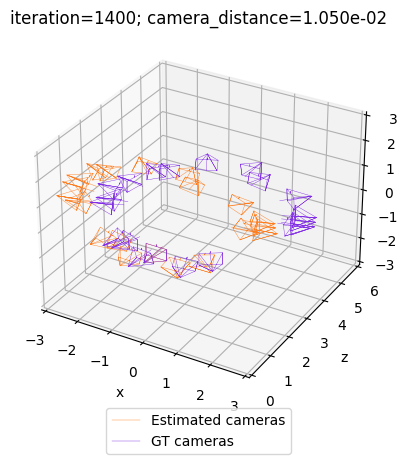

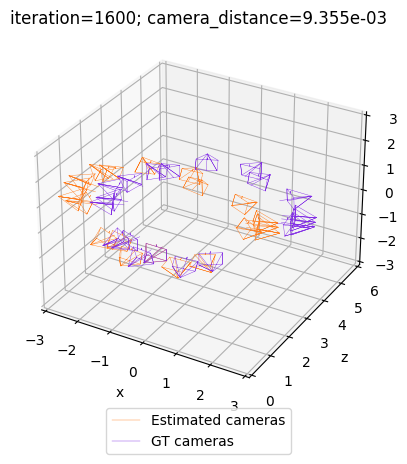

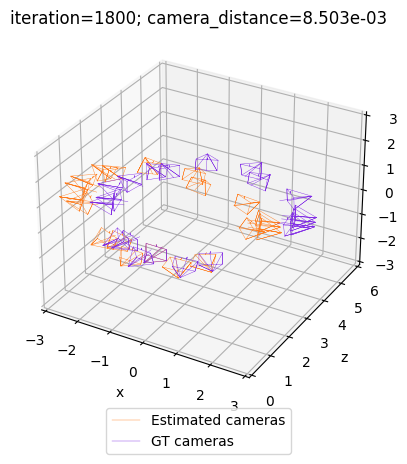

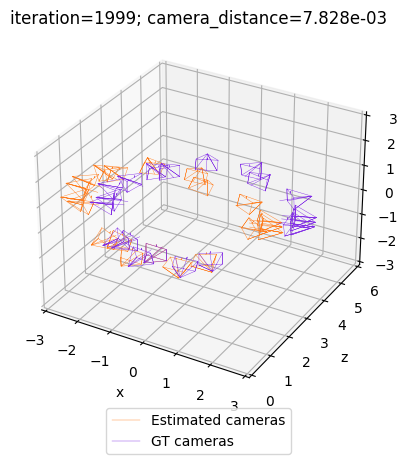

Optimization finished.


In [9]:
# initialize the absolute log-rotations/translations with random entries
log_R_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)
T_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)

# furthermore, we know that the first camera is a trivial one
# (check exercise 1.1 above)
log_R_absolute_init[0, :] = 0.
T_absolute_init[0, :] = 0.

# instantiate a copy of the initialization of log_R / T
log_R_absolute = log_R_absolute_init.clone().detach()
log_R_absolute.requires_grad = True
T_absolute = T_absolute_init.clone().detach()
T_absolute.requires_grad = True

# the mask the specifies which cameras are going to be optimized
#     (since we know the first camera is already correct,
#      we only optimize over the 2nd-to-last cameras)
camera_mask = torch.ones(N, 1, dtype=torch.float32, device=device)
camera_mask[0] = 0.

# init the optimizer
optimizer = torch.optim.SGD([log_R_absolute, T_absolute], lr=.1, momentum=0.9)

# run the optimization
n_iter = 2000  # fix the number of iterations

# add a list to memorize loss
loss=[]

for it in range(n_iter):
    # re-init the optimizer gradients
    optimizer.zero_grad()

    # compute the absolute camera rotations as
    # an exponential map of the logarithms (=axis-angles)
    # of the absolute rotations
    R_absolute = so3_exponential_map(log_R_absolute * camera_mask)

    # get the current absolute cameras
    cameras_absolute = PerspectiveCameras(
        R = R_absolute,
        T = T_absolute * camera_mask,
        device = device,
    )

    # compute the relative cameras as a compositon of the absolute cameras
    cameras_relative_composed = \
        get_relative_camera(cameras_absolute, relative_edges)

    # compare the composed cameras with the ground truth relative cameras
    # camera_distance corresponds to $d$ from the description
    camera_distance = \
        calc_camera_distance(cameras_relative_composed, cameras_relative)

    # our loss function is the camera_distance
    camera_distance.backward()

    # apply the gradients
    optimizer.step()

    # plot and print status message
    if it % 200==0 or it==n_iter-1:
        status = 'iteration=%3d; camera_distance=%1.3e' % (it, camera_distance)
        plot_camera_scene(cameras_absolute, cameras_absolute_gt, status)

    #loss
    loss.append(camera_distance.item())

cameras_optimized=cameras_absolute
print('Optimization finished.')


3.1. Download the *cow mesh* and user the function `render_scene` (below) to render it using the cameras of the ground truth. Do the same using the initial values of the estimated cameras.

*You don't need to understand how to set up a renderer now, we'll cover this later on the couser. For now, just focus on analyzing the results.*

In [10]:
# download the cow mesh
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2024-03-30 22:26:09--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.96, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj.3’

cow.obj.3           100%[===================>] 322.91K  --.-KB/s    in 0.03s   

2024-03-30 22:26:09 (11.7 MB/s) - ‘data/cow_mesh/cow.obj.3’ saved [330659/330659]

--2024-03-30 22:26:09--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.96, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl.3’

cow.mtl.3           100%

In [11]:
def render_scene(meshes, cameras, device):
  """
  Renders 3D meshes to a tensor of images.

  Args:
    meshes: a Meshes instance holding the meshes to be rendered
    cameras: a pytorch3D Cameras instance such as PerspectiveCameras
    device: a torch.device

  """
  if len(meshes) != len(cameras):
    meshes = meshes.extend(len(cameras))

  raster_settings = RasterizationSettings(
      image_size=512,
      blur_radius=0.0,
      faces_per_pixel=1,
  )
  lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
  renderer = MeshRenderer(
      rasterizer=MeshRasterizer(
          cameras=cameras,
          raster_settings=raster_settings
      ),
      shader=SoftPhongShader(
          device=device,
          cameras=cameras,
          lights=lights
      )
  )
  return renderer(meshes).detach()


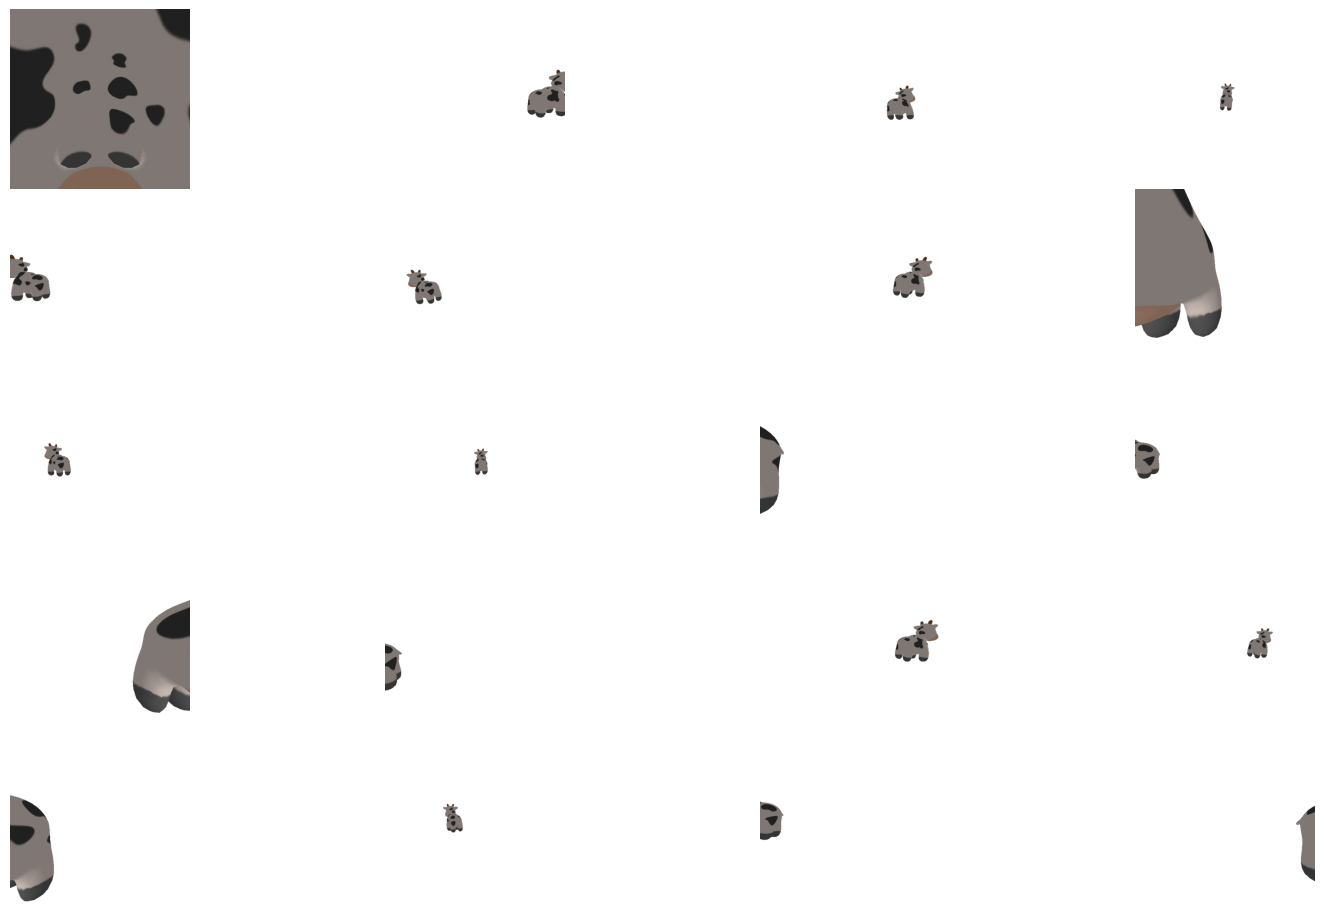

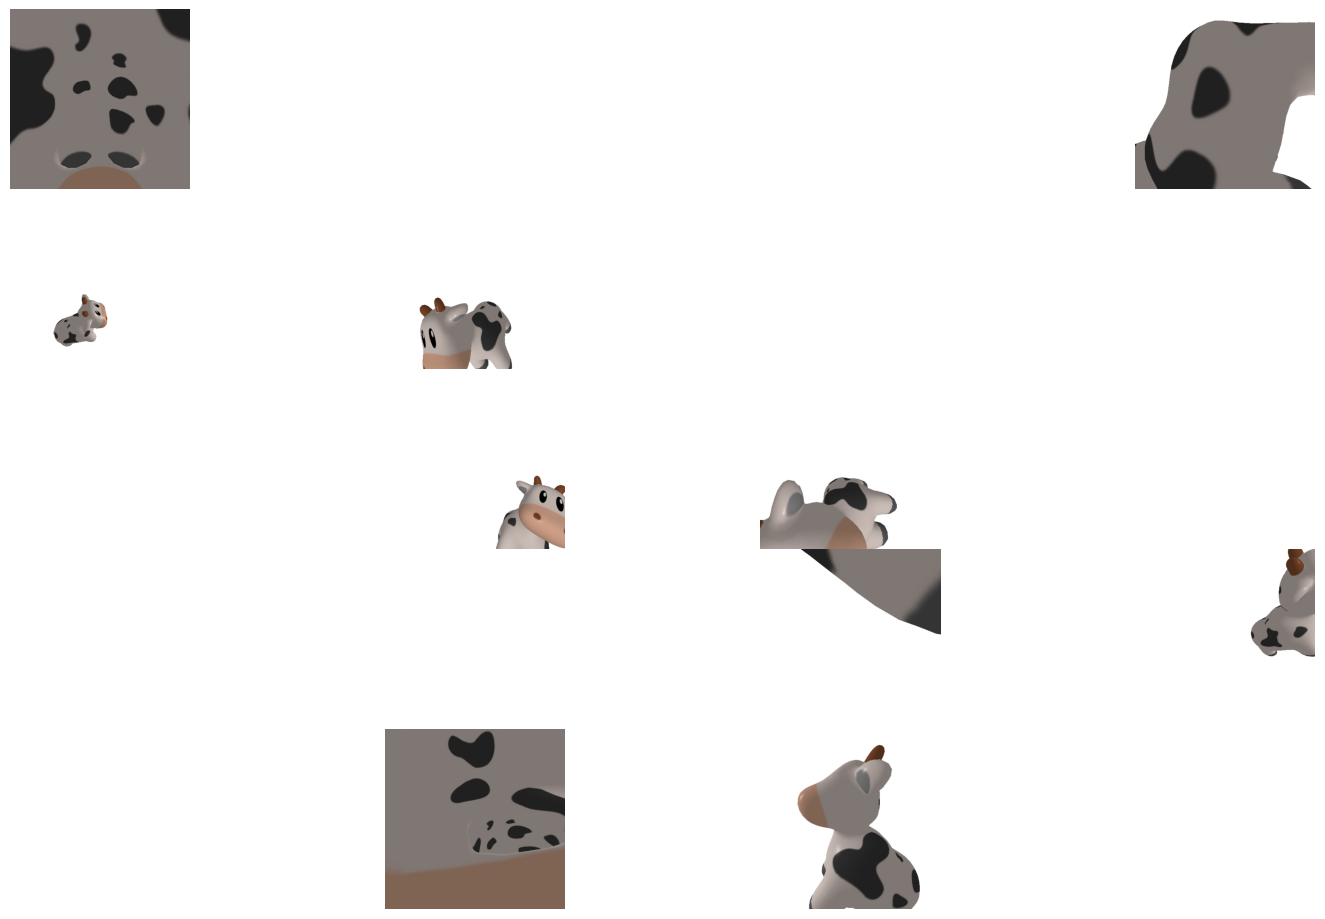

In [12]:
##############################################################################
# Code for 3.1
##############################################################################
#plt.figure(figsize=(20, 40))
from pytorch3d.structures import Meshes
mesh_batch=load_objs_as_meshes(["./data/cow_mesh/cow.obj"]).to(device)
scene_tensors=render_scene(mesh_batch,cameras_absolute_gt,device)
image_grid(scene_tensors.cpu().numpy(),5,4)
#plt.subplots_adjust(wspace=0.1, hspace=0.1)
#plt.gcf().suptitle("Cameras of GT:", fontsize=16)
#plt.show()
"""
for i,image in enumerate(render_scene(mesh_batch,cameras_absolute_gt,device)):
  plt.subplot(10,2,i+1)
  plt.imshow(image[ ..., :3].cpu().numpy())
  plt.axis('off')
plt.show()
"""

init_camera = PerspectiveCameras(
    R = so3_exponential_map(log_R_absolute_init * camera_mask).to(device),
    T = T_absolute_init.to(device),
    device = device,
)
scene_tensors=render_scene(mesh_batch,init_camera,device)
image_grid(scene_tensors.cpu().numpy(),5,4)
#plt.gcf().suptitle("Initial values of estimated cameras:", fontsize=16)
#plt.show()

3.2 Run the optimization loop and plot the  *loss vs iteration* graph.

**[Extra] E.1: Can you do better (improve the approximation)?**

3.3 Render the images again, now using the ground truth cameras and the optimized cameras. Describe the results qualitatively.

**[Extra] E.2: Use another representation for rotation matrices to solve the bundle adjustment problem.**

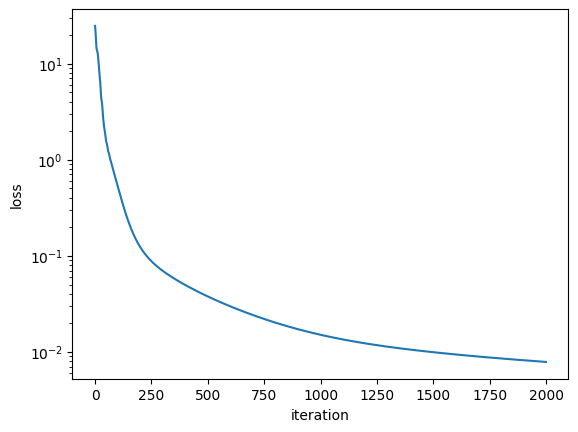

In [13]:
##############################################################################
# Code and explanation for 3.2 - 3.3 (and extras)
##############################################################################

# 3.2
# The optimization code mentioned above has been modified to record the loss. This section outputs those losses. To better present the loss, we use a log scale for the y-axis.
plt.plot(loss)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.yscale('log')

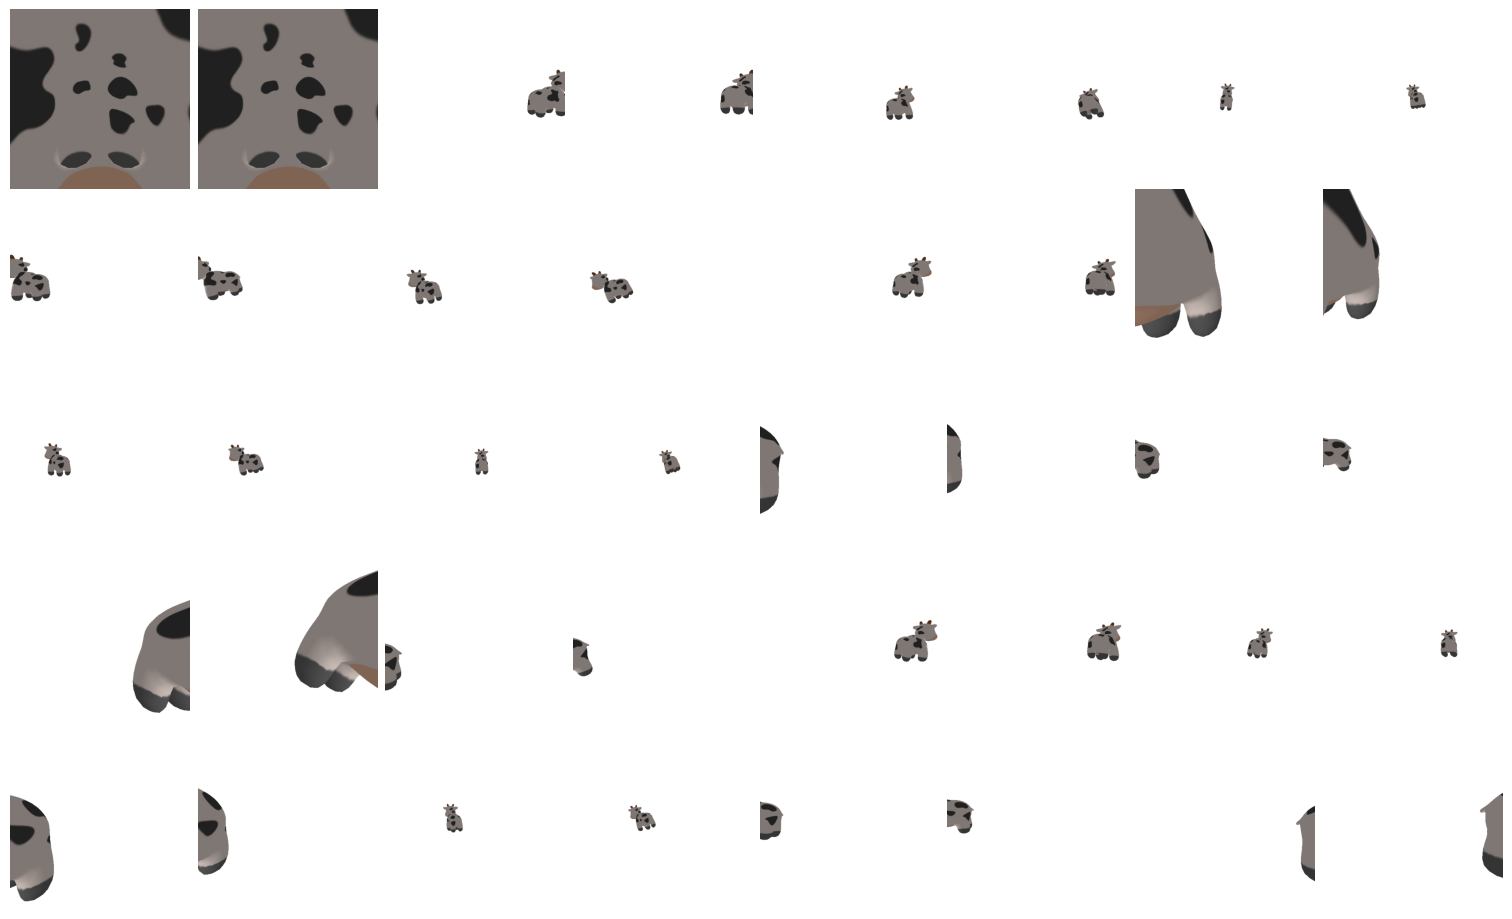

In [14]:
# 3.3
# To compare the results of GT camaeras and optimized camera, we plot them in pairs.
# For example, the first pair consists of the first and second plots in the results, representing the first camera from the GT cameras and the first camera from the optimized camera, respectively.
# The discussion is provided in the text section below.

scene_tensors1=render_scene(mesh_batch,cameras_absolute_gt,device)
scene_tensors2=render_scene(mesh_batch,cameras_optimized,device)
result_list = []
num_items = scene_tensors1.size(0)
for i in range(num_items):
    result_list.append(scene_tensors1[i])
    result_list.append(scene_tensors2[i])
scene_tensors = torch.stack(result_list, dim=0)

image_grid(scene_tensors.cpu().numpy(),5,8)

### Discussion for problem 3.3

All result pairs consist of images depicting the same part of the cow. However, we noticed that there are still slight differences between the results from the GT camera and those from the optimized camera.

# E.1

In several optimazation experienments, we have observed that the final result of the optimation is highly dependent on the initial value of the R and T. If the camera set is initialized to be very far from the GT cameras, then the optimization takes more iterations to make sure the `camera_distance` converges to a small enough value. For only 2000 iterations, the `camera_distance` decrease only to the e-03 scale.

The most brute-force way to improve it is increase the number of iterations. However, this way will increase computation time without a proportional decrease in `camera_distance`.

Below we explore the effectiveness of learning rate decay in improving the approximation without increasing computation cost.

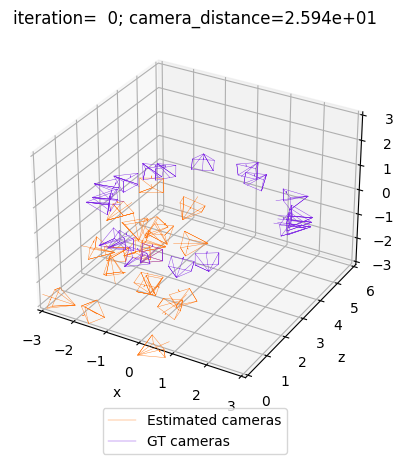

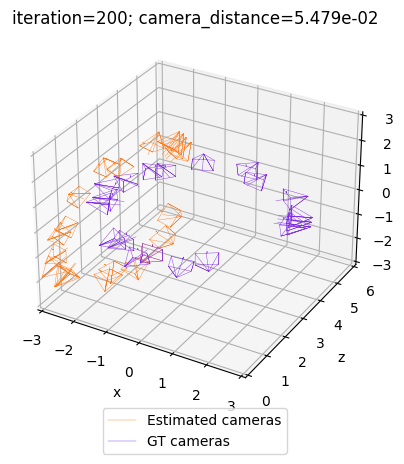

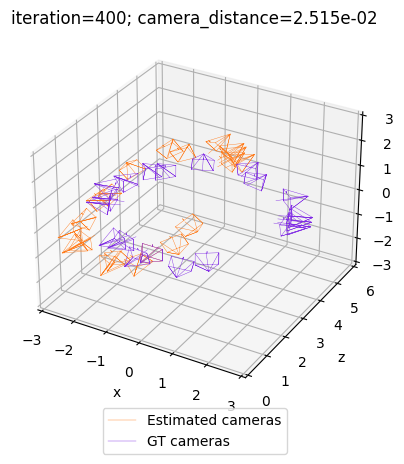

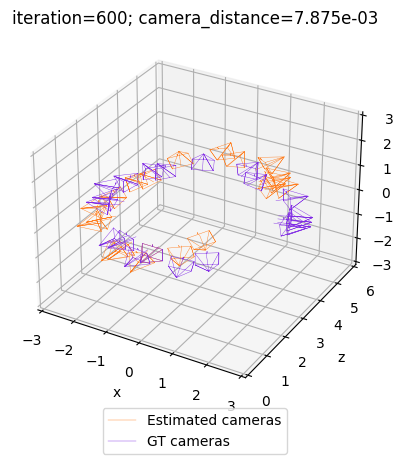

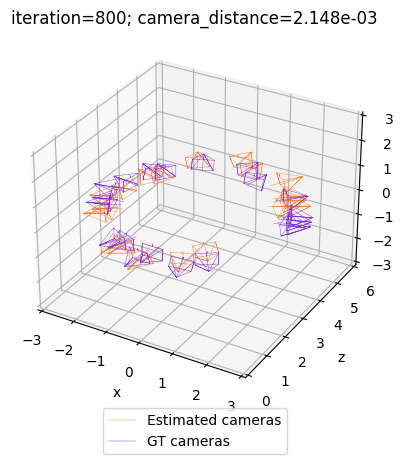

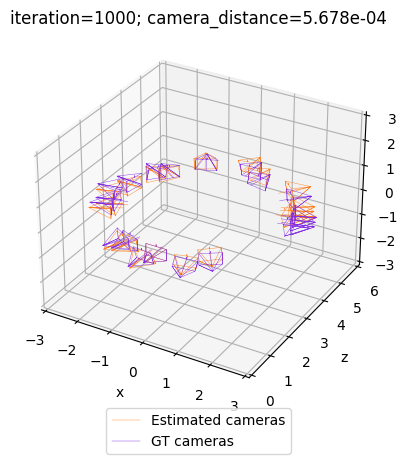

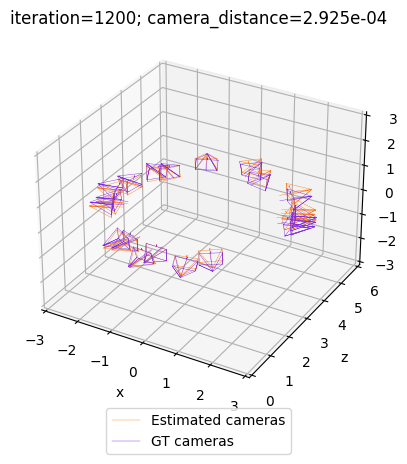

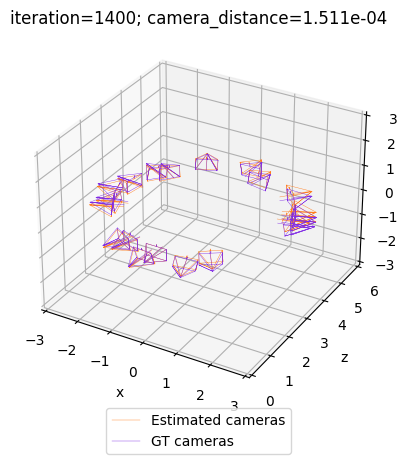

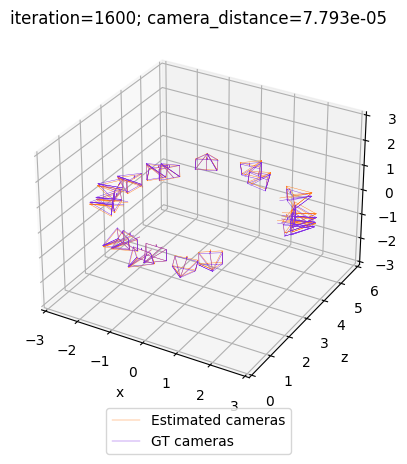

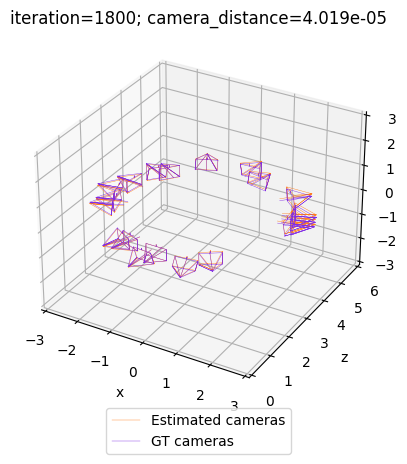

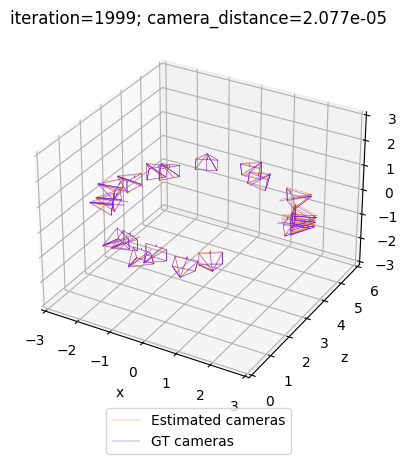

Optimization finished.


In [15]:
# initialize the absolute log-rotations/translations with random entries
log_R_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)
T_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)

# furthermore, we know that the first camera is a trivial one
# (check exercise 1.1 above)
log_R_absolute_init[0, :] = 0.
T_absolute_init[0, :] = 0.

# instantiate a copy of the initialization of log_R / T
log_R_absolute = log_R_absolute_init.clone().detach()
log_R_absolute.requires_grad = True
T_absolute = T_absolute_init.clone().detach()
T_absolute.requires_grad = True

# the mask the specifies which cameras are going to be optimized
#     (since we know the first camera is already correct,
#      we only optimize over the 2nd-to-last cameras)
camera_mask = torch.ones(N, 1, dtype=torch.float32, device=device)
camera_mask[0] = 0.

# init the optimizer
optimizer = torch.optim.SGD([log_R_absolute, T_absolute], lr=0.2, momentum=0.9)

# run the optimization
n_iter = 2000  # fix the number of iterations

# add a list to memorize loss
loss=[]

for it in range(n_iter):
    # re-init the optimizer gradients
    optimizer.zero_grad()

    # compute the absolute camera rotations as
    # an exponential map of the logarithms (=axis-angles)
    # of the absolute rotations
    R_absolute = so3_exponential_map(log_R_absolute * camera_mask)

    # get the current absolute cameras
    cameras_absolute = PerspectiveCameras(
        R = R_absolute,
        T = T_absolute * camera_mask,
        device = device,
    )

    # compute the relative cameras as a compositon of the absolute cameras
    cameras_relative_composed = \
        get_relative_camera(cameras_absolute, relative_edges)

    # compare the composed cameras with the ground truth relative cameras
    # camera_distance corresponds to $d$ from the description
    camera_distance = \
        calc_camera_distance(cameras_relative_composed, cameras_relative)

    # our loss function is the camera_distance
    camera_distance.backward()

    # apply the gradients
    optimizer.step()

    # plot and print status message
    if it % 200==0 or it==n_iter-1:
        status = 'iteration=%3d; camera_distance=%1.3e' % (it, camera_distance)
        plot_camera_scene(cameras_absolute, cameras_absolute_gt, status)

    #loss
    loss.append(camera_distance.item())

    if it == 1000:
      for param_group in optimizer.param_groups:
        param_group['lr'] /= 2


cameras_optimized=cameras_absolute
print('Optimization finished.')


# E.2

We implement quaternions to parameterize roration and then optimize the camera system.

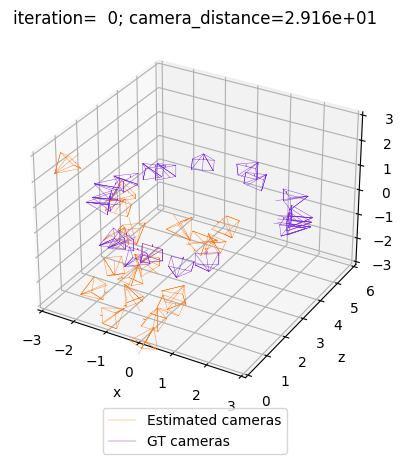

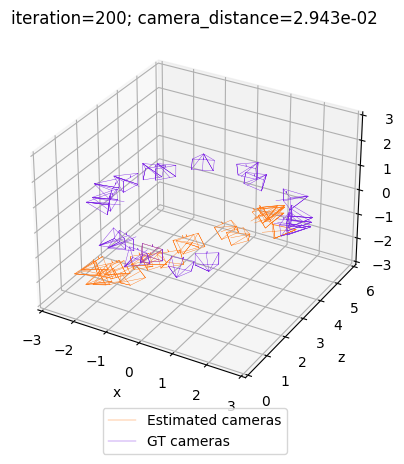

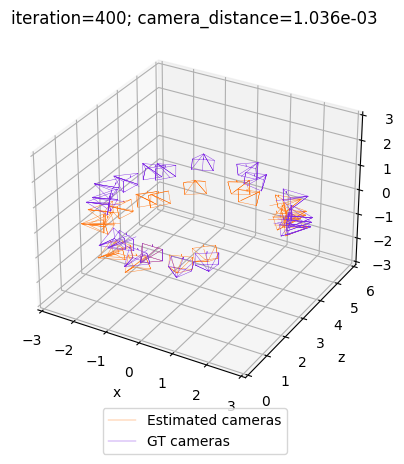

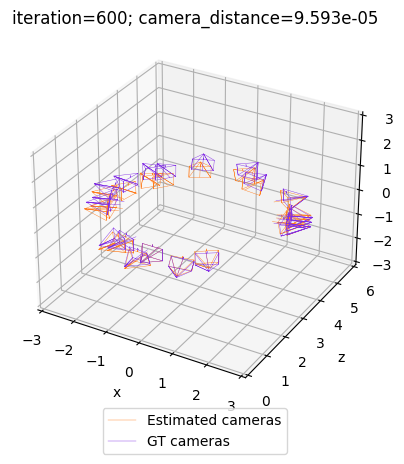

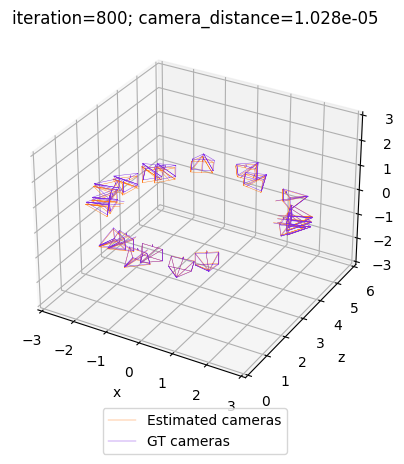

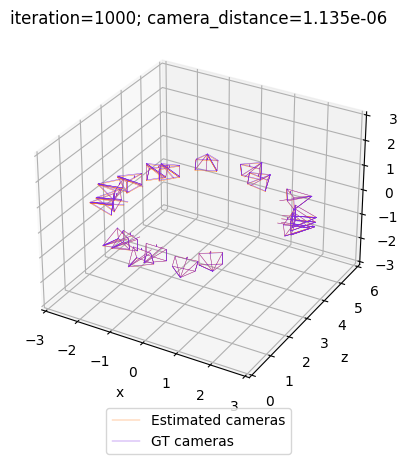

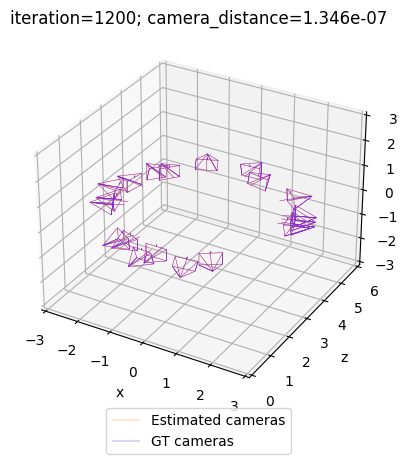

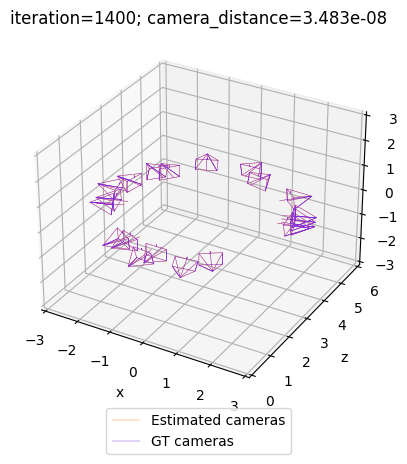

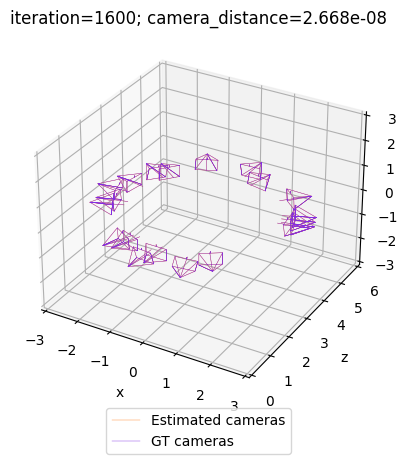

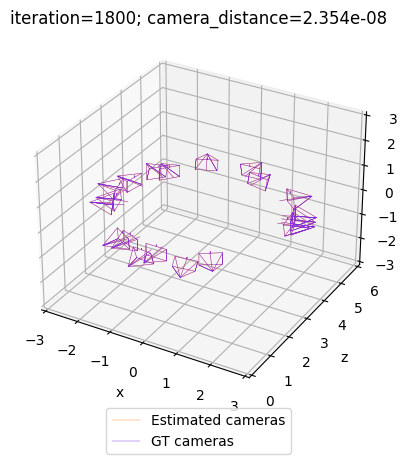

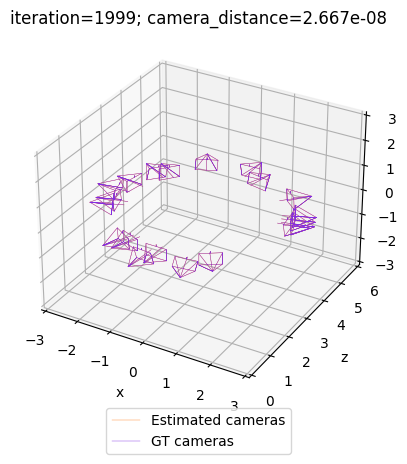

Optimization finished.


In [16]:
from pytorch3d.transforms import quaternion_to_matrix, quaternion_multiply, random_quaternions, matrix_to_quaternion,quaternion_invert

def calc_camera_distance(cam_1, cam_2):
    """
    Calculates the divergence of a batch of pairs of cameras cam_1, cam_2.
    The distance is composed of the cosine of the relative angle between
    the rotation components of the camera extrinsics and the L2 distance
    between the translation vectors.
    """
    # rotation distance
    qua1=matrix_to_quaternion(cam_1.R)
    qua2=matrix_to_quaternion(cam_2.R)
    qua_relative = quaternion_multiply(qua1, quaternion_invert(qua2))
    cos_angle = torch.clamp(qua_relative[..., 0], -1.0, 1.0)
    R_distance = (1. - cos_angle).mean()
    #qua=(qua1*qua2).sum(dim=-1)
    #R_distance=(1-qua).mean()

    # translation distance
    T_distance = ((cam_1.T - cam_2.T)**2).sum(1).mean()
    # the final distance is the sum
    return R_distance + T_distance


# initialize the absolute log-rotations/translations with random entries
qua_init = random_quaternions(N, device=device)
T_absolute_init = torch.randn(N, 3, dtype=torch.float32, device=device)

# furthermore, we know that the first camera is a trivial one
# (check exercise 1.1 above)
qua_init[0] = torch.tensor([1., 0., 0., 0.], device=device)
T_absolute_init[0, :] = 0.

# instantiate a copy of the initialization of log_R / T
qua = qua_init.clone().detach()
qua.requires_grad = True
T_absolute = T_absolute_init.clone().detach()
T_absolute.requires_grad = True

# the mask the specifies which cameras are going to be optimized
#     (since we know the first camera is already correct,
#      we only optimize over the 2nd-to-last cameras)
camera_mask = torch.ones(N, 1, dtype=torch.float32, device=device)
camera_mask[0] = 0.

# init the optimizer
optimizer = torch.optim.SGD([qua, T_absolute], lr=.1, momentum=0.9)

# run the optimization
n_iter = 2000  # fix the number of iterations

# add a list to memorize loss
loss=[]

for it in range(n_iter):
    # re-init the optimizer gradients
    optimizer.zero_grad()

    # compute the absolute camera rotations as
    # an exponential map of the logarithms (=axis-angles)
    # of the absolute rotations
    R_absolute = quaternion_to_matrix(qua)

    # get the current absolute cameras
    cameras_absolute = PerspectiveCameras(
        R = R_absolute,
        T = T_absolute * camera_mask,
        device = device,
    )

    # compute the relative cameras as a compositon of the absolute cameras
    cameras_relative_composed = \
        get_relative_camera(cameras_absolute, relative_edges)

    # compare the composed cameras with the ground truth relative cameras
    # camera_distance corresponds to $d$ from the description
    camera_distance = \
        calc_camera_distance(cameras_relative_composed, cameras_relative)

    # our loss function is the camera_distance
    camera_distance.backward()

    # apply the gradients
    optimizer.step()
    with torch.no_grad():
      qua /= torch.norm(qua, dim=1, keepdim=True)
      qua[0] = torch.tensor([1., 0., 0., 0.], device=device)
    # plot and print status message
    if it % 200==0 or it==n_iter-1:
        status = 'iteration=%3d; camera_distance=%1.3e' % (it, camera_distance)
        plot_camera_scene(cameras_absolute, cameras_absolute_gt, status)

    #loss
    loss.append(camera_distance.item())

cameras_optimized=cameras_absolute
print('Optimization finished.')


Below, we compare the ground truth cameras and the optimized cameras using quaternions, similar to problem 3.3.

We observed that the results from the ground truth cameras and the quaternions are almost identical.

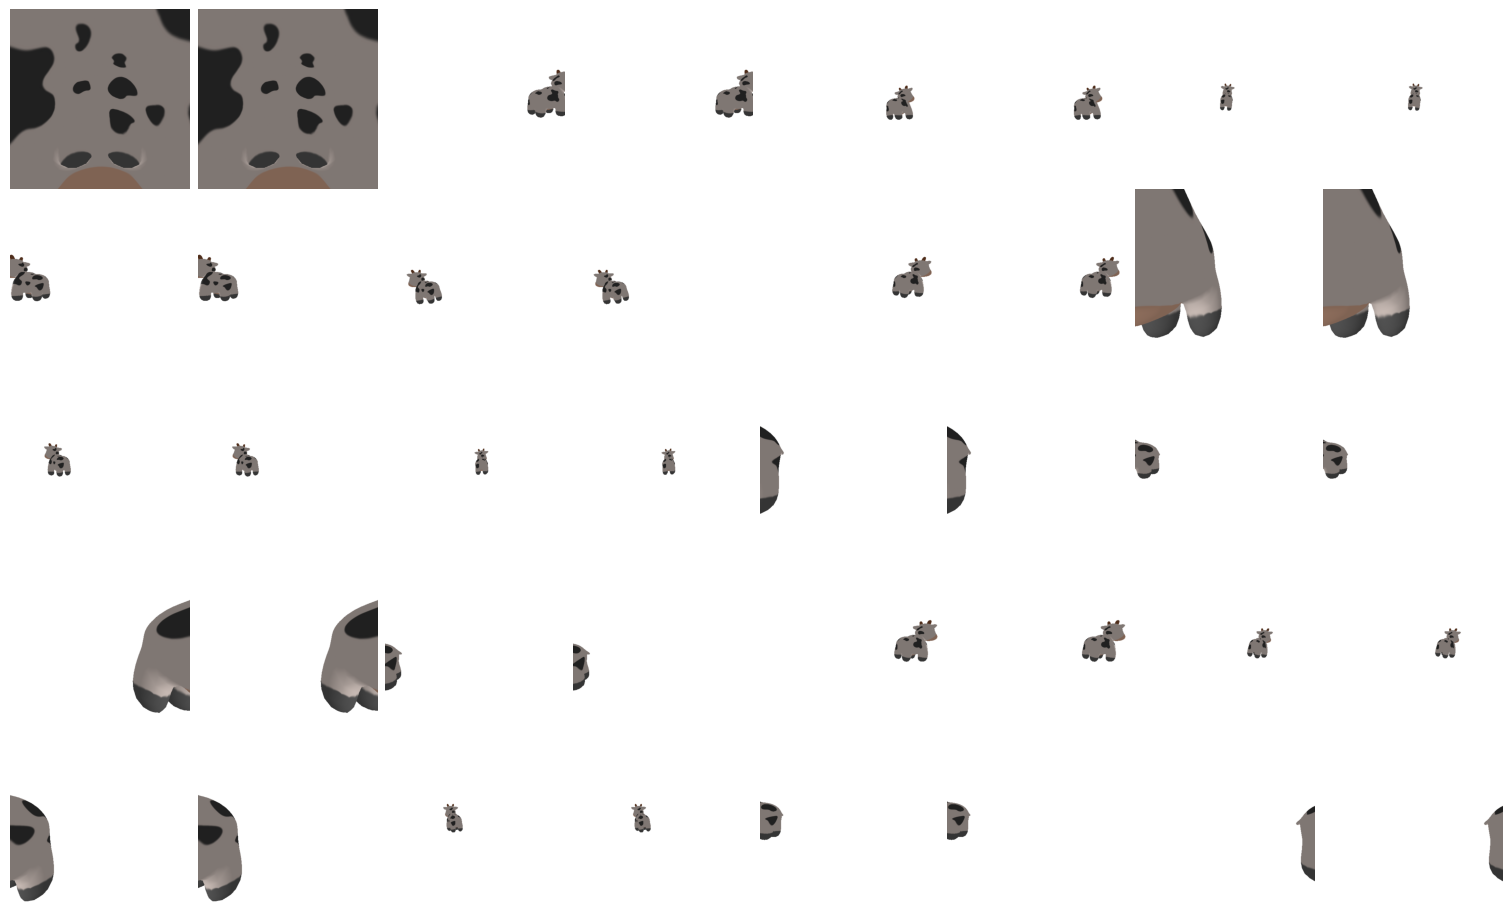

In [17]:
scene_tensors1=render_scene(mesh_batch,cameras_absolute_gt,device)
scene_tensors2=render_scene(mesh_batch,cameras_optimized,device)
result_list = []
num_items = scene_tensors1.size(0)
for i in range(num_items):
    result_list.append(scene_tensors1[i])
    result_list.append(scene_tensors2[i])
scene_tensors = torch.stack(result_list, dim=0)

image_grid(scene_tensors.cpu().numpy(),5,8)